In [1]:
from pystk2_gymnasium.stk_wrappers import ConstantSizedObservations, PolarObservations, DiscreteActionsWrapper
from pystk2_gymnasium.wrappers import FlattenerWrapper
from stk_actor.wrappers import PreprocessObservationWrapper

import ipyparallel
import torch
import tqdm
import pandas as pd
import seaborn as sns

In [2]:


def eval_agent(args):

    from stk_actor.agent import UnifiedSACPolicy
    from stk_actor.wrappers import PreprocessObservationWrapper
    from pystk2_gymnasium.stk_wrappers import ConstantSizedObservations, PolarObservations, DiscreteActionsWrapper
    from pystk2_gymnasium.wrappers import FlattenerWrapper
    from stk_actor.wrappers import PreprocessObservationWrapper

    import gymnasium as gym
    import torch
    from pystk2_gymnasium import AgentSpec
    from stable_baselines3 import PPO

    agent_name, statedict_path, net_arch, activation_fn, mean, std, state_items, state_karts, state_paths, track, difficulty, num_kart, laps, repeat_id = args

    def wrapper_func(state_items, state_karts, state_paths, env):
        return PreprocessObservationWrapper(
            FlattenerWrapper(
                DiscreteActionsWrapper(
                    PolarObservations(
                        ConstantSizedObservations(
                            env,
                            state_items = state_items,
                            state_karts = state_karts, 
                            state_paths = state_paths,
                        )
                    )
                )
            ), 
            ret_dict=False, 
            norm=False,
        )


    env = gym.make(
        "supertuxkart/full-v0",
        render_mode=None,
        agent=AgentSpec(use_ai=False, name="walid"),
        track=track,
        num_kart=num_kart,
        difficulty=difficulty,
    )
    env = wrapper_func(state_items, state_karts, state_paths, env)

    model = PPO(
        "MlpPolicy", 
        env, 
        policy_kwargs = dict(net_arch=net_arch, activation_fn=activation_fn,), 
        device='cpu',
    )
    action_dims = [space.n for space in env.action_space]
    unified_policy = UnifiedSACPolicy(
        env.observation_space, 
        action_dims, 
        net_arch=net_arch, 
        activation_fn=activation_fn
    )
    unified_policy.load_state_dict(torch.load(statedict_path, weights_only=True))
    model.policy.load_state_dict(unified_policy.shared.state_dict())

    obs, *_ = env.reset()
    records = []

    done, truncated = False, False
    ix = 0
    cumreward = 0
    
    while not (done or truncated):
        obs = torch.tensor(obs)
        if mean is not None and std is not None:
            obs = (obs - mean) / (std + 1e-8)

        action, _ = model.predict(obs, deterministic=True)

        obs, reward, done, truncated, info, = env.step(action)
        cumreward += reward

        records.append({
            'agent_name': agent_name,
            'step' : ix,
            'rep' : repeat_id,
            'reward' : reward,
            'cumreward' : cumreward,
            'num_kart' : num_kart,
            'difficulty' : difficulty,
            'laps' : laps,
        })

        ix += 1

    env.close()
    return records



def parallel_run_episodes(args,):
    client = ipyparallel.Client()
    dview = client[:]

    dview.push({'eval_agent': eval_agent})
    results = dview.map(eval_agent, args, )

    print('running:', len(args))
    
    records = []
    for rec in tqdm.tqdm(results, total=len(args)):
        records.extend(rec)

    client.close()
    return records

def wrapper_func(state_items, state_karts, state_paths, env):
    return PreprocessObservationWrapper(
        FlattenerWrapper(
            DiscreteActionsWrapper(
                PolarObservations(
                    ConstantSizedObservations(
                        env,
                        state_items = state_items,
                        state_karts = state_karts, 
                        state_paths = state_paths,
                    )
                )
            )
        ), 
        ret_dict=False, 
        norm=False,
    )



## Eval BHC Agents

In [ ]:
path = 'stk_actor/trained_agents/'

agents = [
    [
        'normed_behavioral_cloning_num5',
        path+'normed_behavioral_cloning_num5/statedict',
        path+'normed_behavioral_cloning_num5/buffer_mean',
        path+'normed_behavioral_cloning_num5/buffer_std',
        5, 5 ,5,
    ],
    [
        'normed_behavioral_cloning_num10',
        path+'normed_behavioral_cloning_num10/statedict',
        path+'normed_behavioral_cloning_num10/buffer_mean',
        path+'normed_behavioral_cloning_num10/buffer_std',
        10,10,10,
    ],
    [
        'non_normed_behavioral_cloning_num5',
        path+'non_normed_behavioral_cloning_num5/statedict',
        None,
        None,
        5, 5 ,5,
    ],
    [
        'non_normed_behavioral_cloning_num10',
        path+'non_normed_behavioral_cloning_num10/statedict',
        None,
        None,
        10,10,10,
    ],
]

net_arch=[1024,1024,1024]
activation_fn=torch.nn.Tanh

tracks = ['black_forest','olivermath','minigolf','gran_paradiso_island', 'candela_city', 'mines', 'snowmountain','abyss',
 'cornfield_crossing', 'hacienda','lighthouse', 'snowtuxpeak', 'zengarden', 'fortmagma','ravenbridge_mansion', 'cocoa_temple', 'sandtrack', 'scotland', 'stk_enterprise', 'volcano_island','xr591',       
]

args_list = []

for agent_name, statedict_path, mean_path, std_path, state_items, state_karts, state_paths in agents:
    

    mean, std = None, None
    if mean_path is not None:   
        mean = torch.load(mean_path, map_location='cpu', weights_only=True)
    if std_path is not None:
        std = torch.load(std_path, map_location='cpu', weights_only=True)


    nb_repeats = 1
    for track in tqdm.tqdm(tracks):
        for repeat_id in range(nb_repeats):
            for laps in [1]:
                for num_kart in [10]:
                    for difficulty in [0,1,2]:
                        args_list.append(
                            (
                                agent_name, 
                                statedict_path, net_arch, activation_fn,
                                mean, std, 
                                state_items, state_karts, state_paths, track, difficulty, num_kart, laps, repeat_id
                            )
                        )


100%|██████████| 21/21 [00:00<00:00, 374810.14it/s]


In [ ]:
records = parallel_run_episodes(args_list)

running: 252


100%|██████████| 252/252 [18:02<00:00,  4.30s/it]  


In [ ]:
df = pd.DataFrame.from_records(records)
df

,agent_name,step,rep,reward,cumreward,num_kart,difficulty,laps
0,normed_behavioral_cloning_num5,0,0,0.500000,0.500000,10,0,1
1,normed_behavioral_cloning_num5,1,0,0.500000,1.000000,10,0,1
2,normed_behavioral_cloning_num5,2,0,0.500000,1.500000,10,0,1
3,normed_behavioral_cloning_num5,3,0,0.500000,2.000000,10,0,1
4,normed_behavioral_cloning_num5,4,0,0.500000,2.500000,10,0,1
...,...,...,...,...,...,...,...,...
643979,non_normed_behavioral_cloning_num10,1495,0,-0.099933,-109.528366,10,2,1
643980,non_normed_behavioral_cloning_num10,1496,0,-0.099939,-109.628305,10,2,1
643981,non_normed_behavioral_cloning_num10,1497,0,-0.099915,-109.728220,10,2,1
643982,non_normed_behavioral_cloning_num10,1498,0,-0.102789,-109.831009,10,2,1


<Axes: xlabel='step', ylabel='cumreward'>

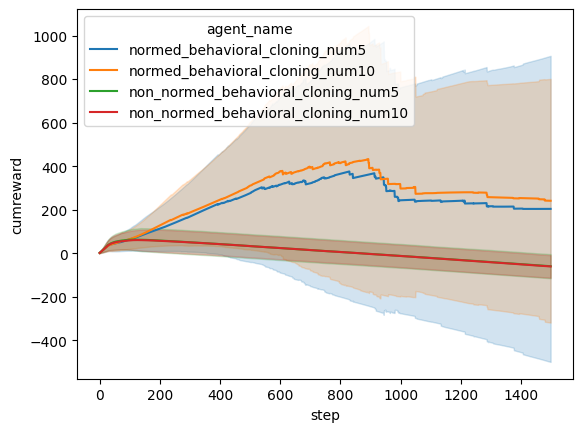

In [ ]:
sns.lineplot(df, x='step', y='cumreward', errorbar='sd', hue='agent_name')

## Eval RL Agents

In [14]:
path = 'stk_actor/trained_agents/'

agents = [
    # [
    #     'normed_behavioral_cloning_num5',
    #     path+'normed_behavioral_cloning_num5/statedict',
    #     path+'normed_behavioral_cloning_num5/buffer_mean',
    #     path+'normed_behavioral_cloning_num5/buffer_std',
    #     5,5,5,
    # ],
    # [
    #     'normed_a2c_num5_no_init',
    #     path+'normed_a2c_num5_no_init/statedict',
    #     path+'normed_a2c_num5_no_init/buffer_mean',
    #     path+'normed_a2c_num5_no_init/buffer_std',
    #     5,5,5,
    # ],
    # [
    #     'normed_ppo_num5_no_init',
    #     path+'normed_ppo_num5_no_init/statedict',
    #     path+'normed_ppo_num5_no_init/buffer_mean',
    #     path+'normed_ppo_num5_no_init/buffer_std',
    #     5,5,5,
    # ],
    [
        'normed_a2c_num5_best',
        path+'normed_a2c_num5_best/statedict',
        path+'normed_a2c_num5_best/buffer_mean',
        path+'normed_a2c_num5_best/buffer_std',
        5,5,5,
    ],
    [
        'normed_ppo_num5_best',
        path+'normed_ppo_num5_best/statedict',
        path+'normed_ppo_num5_best/buffer_mean',
        path+'normed_ppo_num5_best/buffer_std',
        5,5,5,
    ],
]

net_arch=[1024,1024,1024]
activation_fn=torch.nn.Tanh

tracks = ['black_forest','olivermath','minigolf','gran_paradiso_island', 'candela_city', 'mines', 'snowmountain','abyss',
 'cornfield_crossing', 'hacienda','lighthouse', 'snowtuxpeak', 'zengarden', 'fortmagma','ravenbridge_mansion', 'cocoa_temple', 'sandtrack', 'scotland', 'stk_enterprise', 'volcano_island','xr591',       
]

args_list = []

for agent_name, statedict_path, mean_path, std_path, state_items, state_karts, state_paths in agents:
    

    mean, std = None, None
    if mean_path is not None:   
        mean = torch.load(mean_path, map_location='cpu', weights_only=True)
    if std_path is not None:
        std = torch.load(std_path, map_location='cpu', weights_only=True)


    nb_repeats = 1
    for track in tqdm.tqdm(tracks):
        for repeat_id in range(nb_repeats):
            for laps in [1]:
                for num_kart in [10]:
                    for difficulty in [0,1,2]:
                        args_list.append(
                            (
                                agent_name, 
                                statedict_path, net_arch, activation_fn,
                                mean, std, 
                                state_items, state_karts, state_paths, track, difficulty, num_kart, laps, repeat_id
                            )
                        )


100%|██████████| 21/21 [00:00<00:00, 313453.32it/s]


In [15]:
records = parallel_run_episodes(args_list)

running: 126


100%|██████████| 126/126 [07:56<00:00,  3.78s/it]  


In [ ]:
# df = pd.read_csv('res1.csv')
# df[[not x for x in df['agent_name'].str.contains('normed_a2c_num5_best').tolist()]].to_csv("res1.csv")

In [ ]:
df = pd.concat(
    [
        pd.DataFrame.from_records(records),
        pd.read_csv('res1.csv')
    ]
)
# df.to_csv('res1.csv')

<Axes: xlabel='step', ylabel='cumreward'>

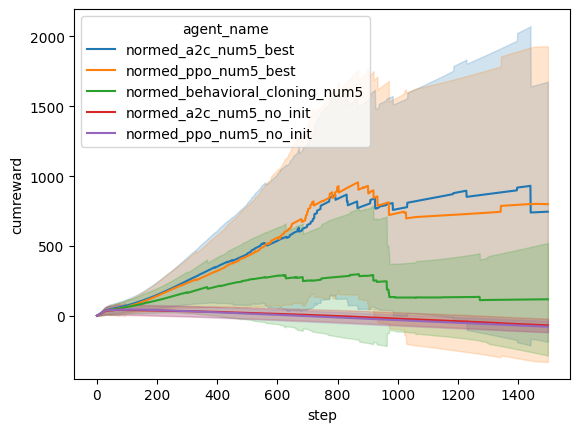

In [12]:
sns.lineplot(
    # df[[not x for x in df['agent_name'].str.contains('ppo').tolist()]], x='step', y='cumreward', errorbar='sd', hue='agent_name'
    df, x='step', y='cumreward', errorbar='sd', hue='agent_name'
)